In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [5]:
%matplotlib inline

In [12]:
import scipy.fftpack

def smooth_data(data, window):
    return np.convolve(y, np.ones(window)/window, mode='same')

# Importing and cleaning data
df = pd.read_csv("short_term_rates.csv")
df1 = df.iloc[:, [0, 4]]
df1 = df1.iloc[5:, :]
df1["Series Description"] = pd.to_datetime(df1["Series Description"])
df1.iloc[:, 1] = pd.to_numeric(df1.iloc[:, 1], errors="coerce")
df1 = df1.dropna()
df1.iloc[:, 1] = df1.iloc[:, 1].astype('float64')

In [16]:
size = 500
padding = 50
total_len = len(df1)
margin = 10

real_x = df1.iloc[:, 0].values
real_y = df1.iloc[:, 1].values

In [29]:
def time_diff(x1, x2):
    diff = x2 - x1
    diff = diff / np.timedelta64(1, 'D')
    return diff

a_list = []
ab_list = []
sigma_list = []

for i in range(padding, total_len - padding - margin):
    start = i - padding
    end = i + size + padding

    x = real_x[start: end]
    y = real_y[start:end]
    smooth_y = smooth_data(y,padding)
    smooth_y = smooth_y[padding:-1 * padding]
    x = x[padding:-1 * padding]
    y = y[padding:-1 * padding]
    
    total_days_diff = time_diff(x[0], x[len(x) - 1])
    dt = 1 / total_days_diff
    deltaT = (np.diff(x) / np.timedelta64(1, 'D')) * dt
    deltaR = np.diff(smooth_y)
    R = smooth_y[: -1]
    Rdt = R * deltaT
    
    A = np.column_stack([deltaT, Rdt])
    AT = A.T

    AT_A = AT @ A
    AT_A = AT_A.astype(float)
    inverse_AT_A = np.linalg.inv(AT_A)
    p = (inverse_AT_A @ AT)
    parameters = p @ deltaR
    
    a = -parameters[1]  
    ab = parameters[0]
    a_list.append(a)
    ab_list.append(ab)
    
    diffy = y - smooth_y
    abssum = np.sum(np.abs(diffy)) / size
    sigma = abssum / np.sqrt(dt)
    sigma_list.append(sigma)

    

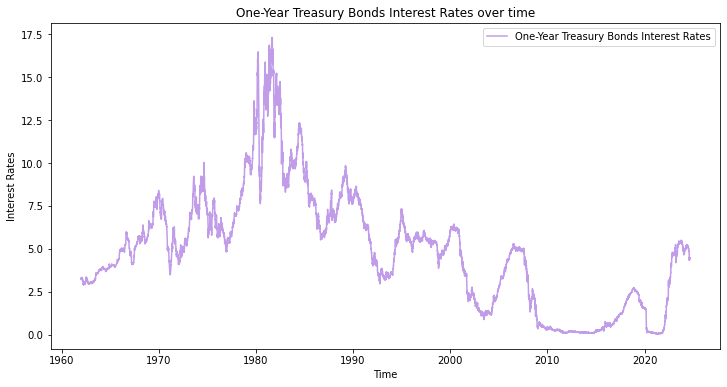

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(real_x[:len(a_list)], real_y[:len(a_list)], label="One-Year Treasury Bonds Interest Rates", color='#c19ce9')
plt.xlabel("Time")
plt.ylabel("Interest Rates")
plt.title(label="One-Year Treasury Bonds Interest Rates over time")
plt.legend()
plt.show()

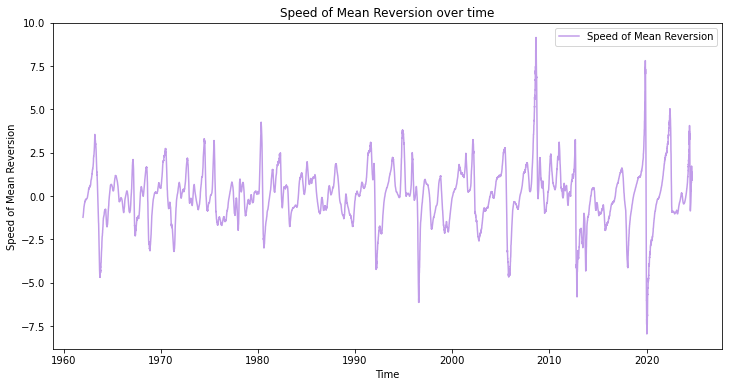

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(real_x[:len(a_list)], a_list, label="Speed of Mean Reversion", color='#c19ce9')
plt.xlabel("Time")
plt.ylabel("Speed of Mean Reversion")
plt.title(label="Speed of Mean Reversion over time")
plt.legend()
plt.show()

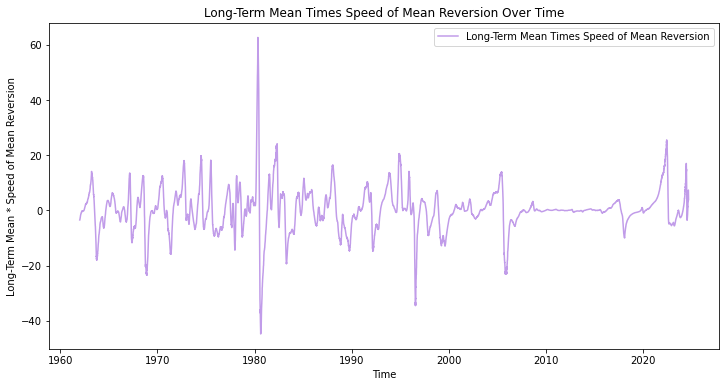

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(real_x[:len(a_list)], ab_list, label="Long-Term Mean Times Speed of Mean Reversion", color='#c19ce9')
plt.xlabel("Time")
plt.ylabel("Long-Term Mean * Speed of Mean Reversion")
plt.title(label="Long-Term Mean Times Speed of Mean Reversion Over Time")
plt.legend()
plt.show()

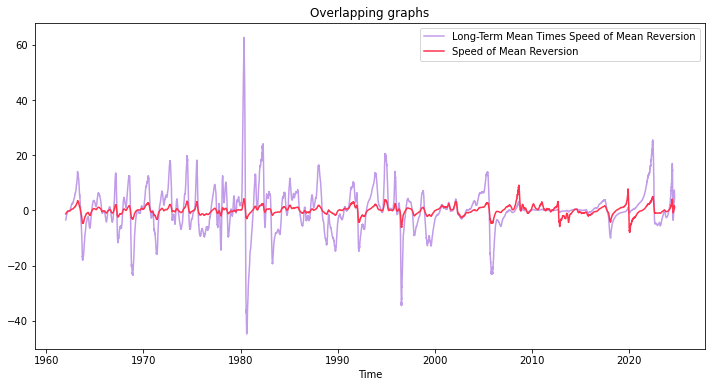

In [38]:
# Over Lapping SMR and LTM * SMR
plt.figure(figsize=(12, 6))
plt.plot(real_x[:len(a_list)], ab_list, label="Long-Term Mean Times Speed of Mean Reversion", color='#c19ce9')
plt.plot(real_x[:len(a_list)], a_list, label="Speed of Mean Reversion", color='#ff334f')
plt.xlabel("Time")
plt.ylabel("")
plt.title(label="Overlapping graphs")
plt.legend()
plt.show()

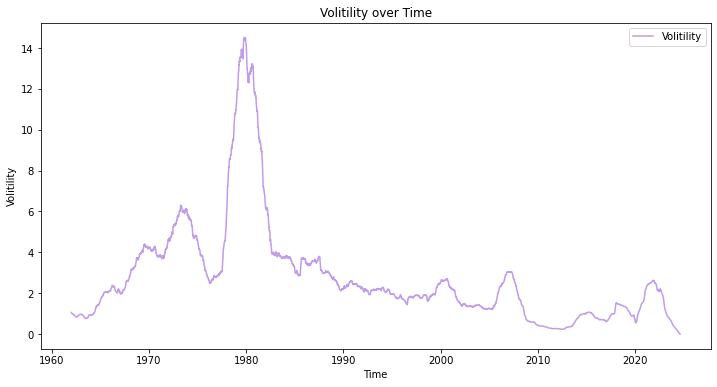

In [41]:
# Volitility Graph
plt.figure(figsize=(12, 6))
plt.plot(real_x[:len(a_list)], sigma_list, label="Volitility", color='#c19ce9')
plt.xlabel("Time")
plt.ylabel("Volitility")
plt.title(label="Volitility over Time")
plt.legend()
plt.show()

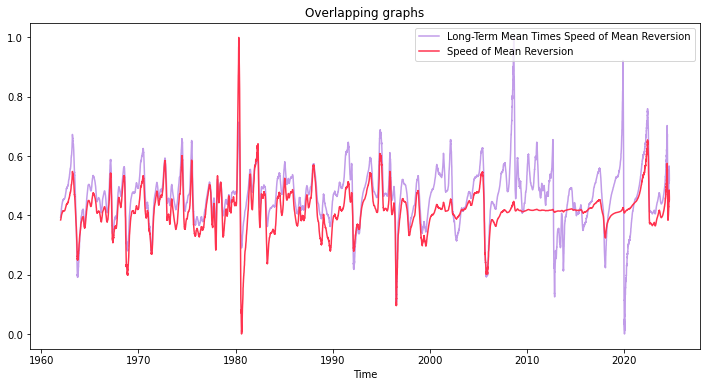

In [45]:
# Normalized a, ab
def normalize_data(data):
    Min = min(data)
    Max = max(data)
    return (data - Min) / (Max - Min)

normalized_a = normalize_data(a_list)
normalized_ab = normalize_data(ab_list)

# Over Lapping SMR and LTM * SMR
plt.figure(figsize=(12, 6))
plt.plot(real_x[:len(a_list)], normalized_a, label="Long-Term Mean Times Speed of Mean Reversion", color='#c19ce9')
plt.plot(real_x[:len(a_list)], normalized_ab, label="Speed of Mean Reversion", color='#ff334f')
plt.xlabel("Time")
plt.ylabel("")
plt.title(label="Overlapping graphs")
plt.legend()
plt.show()

### Results / Intrepretations

In this simulation, I did three simulations. 

The first is to measure the speed of mean reversion. According to this vasicek model, this represents the how fast interest rates would revert to the long-term mean. The graph shows how the speed of rates operate in cycles.

The second is the term I called ab which is the speed of mean reversion times the long term mean. I could not separate the two values after the regression because there are number of times that resulted in a divison by 0 error. The concidental part of this is that both of them tend to go to 0 at the same time making me believe that there exists some numeric limit. Also notice the fact that both the terms a and ab tend to follow a similar trend with peaks at similar locations. 

The final one is the volitility of the interest rates. Considering that the volitility of the Interest rates closely follows the actual interest rates makes me believe that I need to redefine volitility to get